# screeps-experimenting notebook

I use this notebook for trying to understand, investigating and explaining algorithms, parameter choices and other stuff for my experimenting with screeps.


**Table of contents:**

* [Dynamic Road Building with the Use of Pheromone Trails](#dynamic-path-building)

## Dynamic Road Building with the Use of Pheromone Trails <a class="anchor" id="dynamic-path-building"></a>

Any autonomous colony needs some form of dynamic road building to allow the creeps to move around more efficiently. The algorithm I've decided to investigate is based on communication through changes to the local environment. The idea is similar to how ants form paths and how some bacteria communicate and it allows for very "organic" path building that reacts to changes in creep behaviour as time passes.

The idea itself is simple: creeps deposit pheromones where they move, which evaporates over time, and roads are built where the pheromone concentration is above a certain threshold, $\theta$. This way paths will be built where creeps move often and if creeps stop using a path, it will decay and will not be rebuilt. There are a few parameters that need tweaking for it to be efficient however, which is what I'll explore in the following section.

I will use $\phi(t, \mathbf{r})$ for the amount of pheromones in $\mathbf{r}$ at time $t$, where $\mathbf{r}$ denotes spatial coordinates. Most of the time, I will omit $\mathbf{r}$ and just use $\phi(t)$, though.

### Choosing Evaporation Rate and Pheromone Threshold

The evaporation rate is important for making sure that both frequently travelled paths retain a "_high enough_" pheromone level and that other paths that are only traversed once in a while don't have pheromone build-up. The evaporation rate and the threshold for when to build roads are the two main parameters deciding the performance of the method.

For this section I will only consider changes in pheromone concentration in a single point as a function of time. Therefore, I will omit the spatial variable $\mathbf{r}$ in all expressions and equations and use $\phi_t$ instead of $\phi(t)$.

Since time is clearly discretized into "ticks" in the world of screeps, $\phi$ is also discrete in time. Pheromone evaporation from one tick to the next is described by the following equation

$\phi_{t+1} = \phi_t (1-\varepsilon),$

where $\varepsilon$ is the evaporation rate. If we consider addition of new pheromones from passing creeps we add another term to the right hand side

$\phi_{t+1} = \phi_t (1-\varepsilon) + \nu_{t+1}.$

Since the choice of unit does not matter, let's consider a pheromone deposit 1 unit (_or let's measure $\phi$ in $\left[\frac{\text{amount of pheromones}}{\text{pheromone amount in a single (standard) deposit}}\,\right]$_). Knowing this, $\nu_t$ can either be 1 or 0. Furthermore, since we are interested in some sort of equilibrium or average visiting frequency, $\nu_t$ can be given a period of $T$ such that every $T$ ticks it is equal to 1.

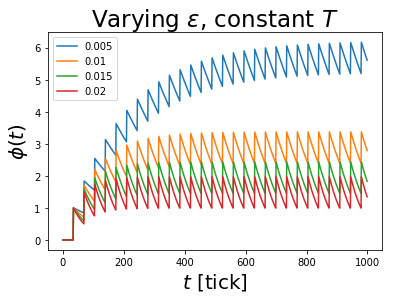

In [25]:
import numpy as np
import matplotlib.pyplot as plt

t_max = 1000
visit_interval = 35
evaporation_rate = np.linspace(0.005, 0.02, 4)

for d in evaporation_rate:
    phi = np.zeros(t_max)
    nu = np.zeros(phi.size)
    nu[0:-1:visit_interval] = 1.0

    for t in range(1, t_max):
        phi[t] = phi[t-1]*(1-d) + nu[t]
    plt.plot(phi)

plt.legend(evaporation_rate)
plt.title('Varying $\epsilon$, constant $T$', size=23)
plt.ylabel('$\phi(t)$', size=20)
plt.xlabel('$t$ [tick]', size=20)
plt.show()

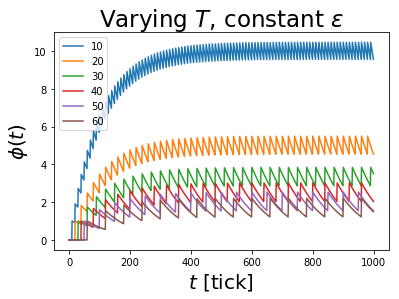

In [4]:
import numpy as np
import matplotlib.pyplot as plt

t_max = 1000
evaporation_rate = 0.01
visit_interval = np.arange(10, 61, 10)

for v in visit_interval:
    phi = np.zeros(t_max)
    nu = np.zeros(phi.size)
    nu[0:-1:v] = 1.0

    for t in range(1, t_max):
        phi[t] = phi[t-1]*(1-evaporation_rate) + nu[t]
    plt.plot(phi)

plt.legend(visit_interval)
plt.title('Varying $T$, constant $\epsilon$', size=23)
plt.ylabel('$\phi(t)$', size=20)
plt.xlabel('$t$ [tick]', size=20)
plt.show()

In the case of a steady frequency of visitation, we can see that pheromone levels quickly reach a steady state. Of course, the amount of pheromones in that steady state depends on the choice of $\varepsilon$. By doing a parameter sweep over $\varepsilon$ and $T$ and averaging the pheromone level during the steady state, we can get a good idea of what $\varepsilon$-$\theta$-pair to choose.

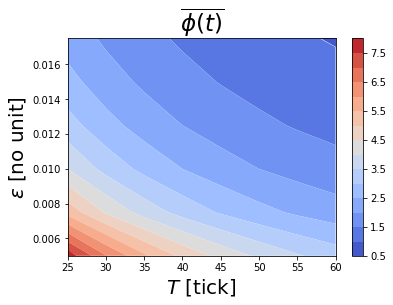

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

t_max = 1000
avg_period = 400

def compute_avg_phi(visit_interval, evaporation_rate):
    phi = np.zeros(t_max)
    nu = np.zeros(t_max)
    nu[0:-1:visit_interval] = 1.0
    
    for t in range(1, t_max):
        phi[t] = phi[t-1] * (1-evaporation_rate) + nu[t]
    return np.mean(phi[-avg_period:])


visit_interval = np.arange(25, 61, 5)
evaporation_rate = np.arange(0.005, 0.02, 0.0025)

V, D = np.meshgrid(visit_interval, evaporation_rate)
avg_phi = np.array([compute_avg_phi(v, d) for v, d in zip(np.ravel(V), np.ravel(D))])
AVG_PHI = avg_phi.reshape(V.shape)

surface = plt.contourf(V, D, AVG_PHI, 15, cmap=cm.coolwarm, antialiased=True)
plt.colorbar(surface)
plt.title('$\\overline{\phi(t)}$', size=23)
plt.xlabel('$T$ [tick]', size=20)
plt.ylabel('$\epsilon$ [no unit]', size=20)
plt.show()

Choosing the appropriate visiting frequency for when a path should be built is not trivial however, and it depends on many creeps are expected to operate (and deposit pheromones) at a given point in time. Without taking that into account for the moment: if we hypothesize that a paths should be built where, on average, a creep passes every 35$^\mathrm{th}$ tick then, looking at the figure above, we see that a possible choice of parameters is $\varepsilon \approx 0.010$ and $\theta \approx 3.0$.